In [3]:
import pandas as pd
import numpy as np
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import pykalman

In [4]:
print("pykalman verison:")
try:
    from importlib import metadata
except ImportError:
    import importlib_metadata as metadata

try:
    print(metadata.version("pykalman"))
except Exception:
    print("unknown")

pykalman verison:
0.9.5


We load some vertical positon data of a guy running in the mountains.

In [5]:
def load_df(fname):
    df = pd.read_csv(fname, na_values=[''],sep=';', encoding = "utf-8", names=["Time (s)", "Position (m)"])
    return df

# import the data for the kalman filtering
fname = 'kalman_data.csv'
df = load_df(fname)

Let's see what the data looks like

In [6]:
df

,Time (s),Position (m)
0,0,0.000000
1,1,0.600000
2,2,1.210000
3,3,1.817999
4,4,2.431995
...,...,...
996,996,672.005596
997,997,672.399868
998,998,672.790720
999,999,673.178173


# Model

Simple linear model taking into account the speed and the acceleration.

In [7]:
def set_velocity_model(df):

    # get the time step
    dt = df.index[1] - df.index[0]

    # transition_matrix
    F = [[1,  dt,   0.5*dt*dt],
         [0,   1,          dt],
         [0,   0,           1]]

    # observation_matrix
    H = [1, 0, 0]

    # transition_covariance
    Q = [[   1,     0,     0],
         [   0,  1e-4,     0],
         [   0,     0,  1e-6]]

    # observation_covariance
    R = [0.04] # max error = 0.6m

    # initial_state_mean
    X0 = [0, 0, 0]

    # initial_state_covariance
    P0 = [[ 10,    0,   0],
          [  0,    1,   0],
          [  0,    0,   1]]

    n_timesteps = df.shape[0]
    n_dim_state = 3
    n_dim_obs = 1

    return df, F, H, Q, R,X0, P0, n_timesteps, n_dim_state, n_dim_obs


def handle_velocity_model(df, key, smoothing=False):

    df, F, H, Q, R,X0, P0, n_timesteps, n_dim_state, n_dim_obs = set_velocity_model(df)
   
    kf = pykalman.KalmanFilter(
        transition_matrices=F,
        observation_matrices=H,
        transition_covariance=Q,
        observation_covariance=R,
        initial_state_mean=X0,
        initial_state_covariance=P0,
        n_dim_obs=n_dim_obs,
        n_dim_state=n_dim_state
    )


    # Masking invalid values
    input_values = np.ma.masked_invalid(df[key].values)
    
    if smoothing:
        #We take the smoothed_state wich considers both sides
        state_means, state_covariances = kf.smooth(input_values)
    else:
        # estimate hidden state
        state_means, state_covariances = kf.filter(input_values)

    """
    state_means is a ndarray of vector. Each vector corresponds to a timestep
    and has 3 elements. position, speed, acceleration
    In order to obtain three columns, a transposition is needed

    state_covariances is a ndarray of dim (n * 3 * 3). The variances are in the
    diagonal [:,0,0] [:,1,1], [:,2,2]
    """

    # transpose the state mean
    state_means = state_means.transpose()

    df['position_filtered'] = state_means[0]
    df['velocity_filtered'] = state_means[1]
    df['acceleration_filtered'] = state_means[2]

    df['position_std'] = np.sqrt(state_covariances[:,0,0])
    df['velocity_std'] = np.sqrt(state_covariances[:,1,1])
    df['acceleration_std'] = np.sqrt(state_covariances[:,2,2])

    return df

Define a function to splot the result of Kalman filtering.

In [8]:
import matplotlib.pyplot as plt
def plot_kalman_filter(df, key, key_std, title):

    #New figure
    fig = plt.figure(figsize = (10,6), dpi=96,
                     facecolor='w', edgecolor='k')

    #Setting the subpolots
    gs = fig.add_gridspec(1,1)
    ax = fig.add_subplot(gs[0 ,0])

    # Plot the points without outliers
    ax.plot(df[key], "g-", label="Filtered position")

    ax.plot(df[key] + df[key_std], "r--", label="+sigma")

    ax.plot(df[key] - df[key_std], "r--", label="-sigma")

    ax.grid()
    ax.legend(loc="upper left")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Position (m)")

    plt.show
    # fig.savefig(fname=title + '.png', dpi=300, format='png')

# Case 1: no missing values

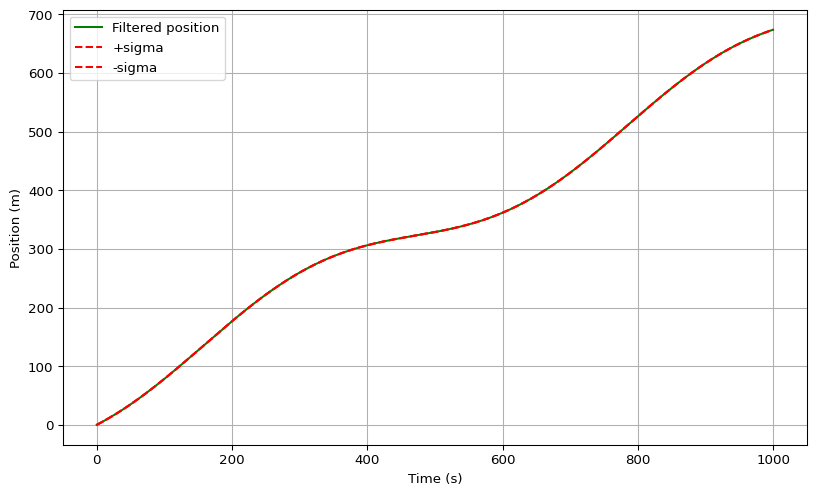

In [11]:
title = '1_kalman_filtering_no_missing_values'
key = "Position (m)"
df2 = handle_velocity_model(df, key, smoothing=False)
plot_kalman_filter(df, 'position_filtered', 'position_std', title)

# Case 2: missing values from 300 to 500

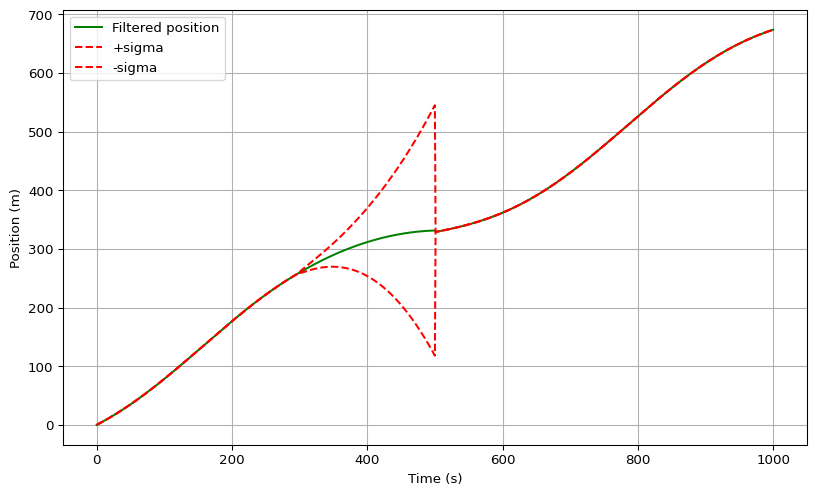

In [14]:
title = '2_kalman_filtering_normal_missing_range'
df2 = df.copy(deep=True)
df2.loc[300:500, key] = np.nan
df2 = handle_velocity_model(df2, key, smoothing=False)
plot_kalman_filter(df2, 'position_filtered', 'position_std', title)

# Case 3: missing values from 300 to 800

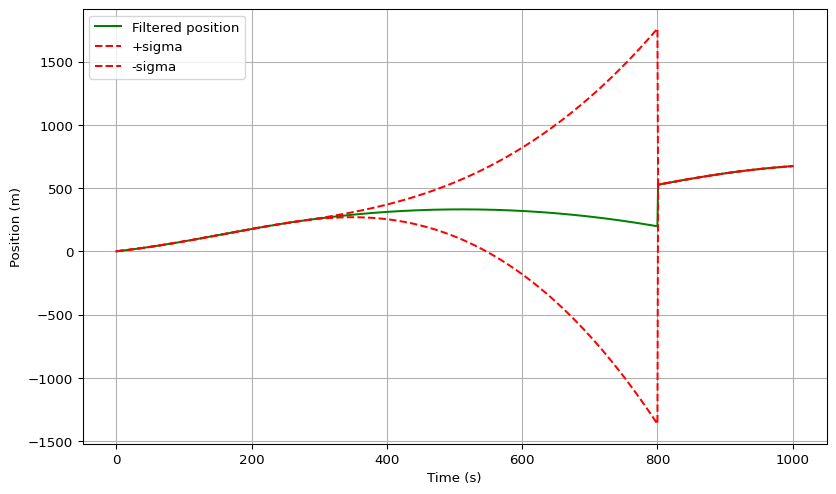

In [16]:
title = '3_kalman_filtering_big_missing_range'
df2 = df.copy(deep=True)
df2.loc[300:800, key] = np.nan
df2 = handle_velocity_model(df2, key, smoothing=False)
plot_kalman_filter(df2, 'position_filtered', 'position_std', title)

# Case 4: missing values from 200 to 400 + 600 to 750

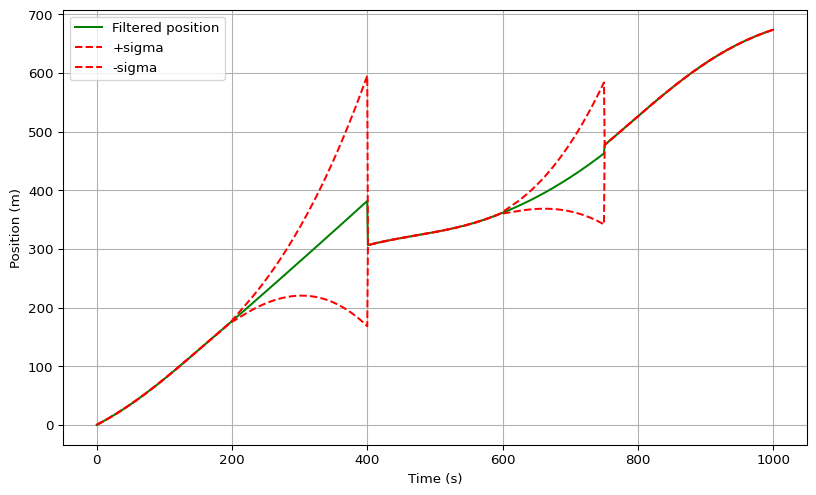

In [18]:
title = '4_kalman_filtering_two_missing_ranges'
df2 = df.copy(deep=True)
df2.loc[200:400, key] = np.nan
df2.loc[600:750, key] = np.nan
df2 = handle_velocity_model(df2, key, smoothing=False)
plot_kalman_filter(df2, 'position_filtered', 'position_std', title)

# Case 5: missing values from 200 to 400 + 600 to 750 + smoothing

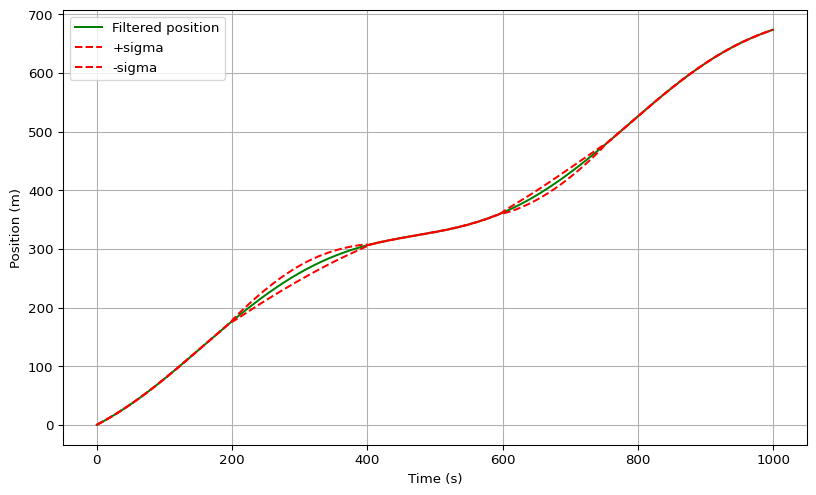

In [20]:
title = '5_kalman_smoohting_two_missing_ranges'
df2 = df.copy(deep=True)
df2.loc[200:400, key] = np.nan
df2.loc[600:750, key] = np.nan
df2 = handle_velocity_model(df2, key, smoothing=True)
plot_kalman_filter(df2, 'position_filtered', 'position_std', title)

# Case 6: missing values from 300 to 800 + smoothing

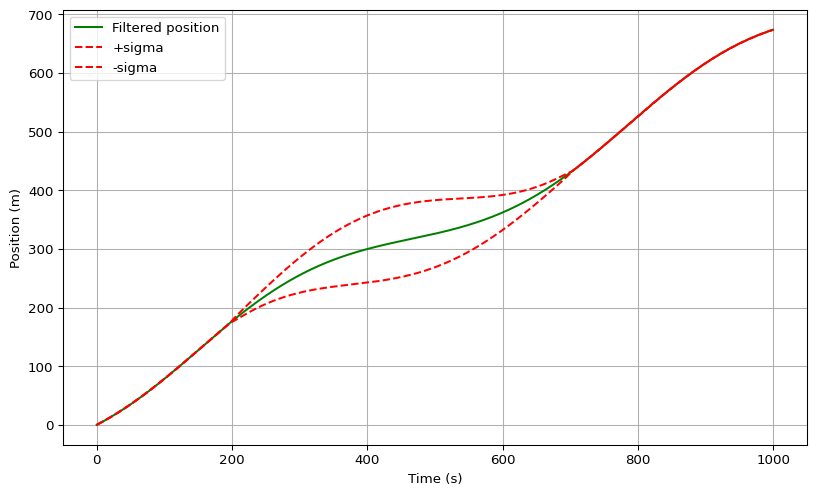

In [22]:
title = '6_kalman_smoohting_big_missing_range'
df2 = df.copy(deep=True)
df2.loc[200:700, key] = np.nan
df2 = handle_velocity_model(df2, key, smoothing=True)
plot_kalman_filter(df2, 'position_filtered', 'position_std', title)